In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import scipy
from matplotlib import colors

import FAIRStream

In [2]:
# csv pool folder directory
csv_pool_path = '/Users/jiaxingqiu/Documents/CAMA_projects/BSI/code/projects/csv_pool'
# current experiment working directory
work_dir = '/Users/jiaxingqiu/Documents/CAMA_projects/BSI/code/projects/case_txp'

In [3]:
# initiate a FAIRStream object instance for BSI project
bsi_stream = FAIRStream.FAIRStream(work_dir)
# take a look at dictionaries in engineer's hands
#bsi_stream.engineer.csv_source_dict
bsi_stream.engineer.variable_dict

Success: Querier has initiated a csv source dictionary in:/Users/jiaxingqiu/Documents/CAMA_projects/BSI/code/projects/case_txp/meta_data/csv_source_dict_demo.json
Success: Querier has initiated a variable dictionary in:/Users/jiaxingqiu/Documents/CAMA_projects/BSI/code/projects/case_txp/meta_data/variable_dict_demo.json
Unable to read sql source dictionary. Use Querier.update_sql_source_dict() to build one.


{'__uid': {'src_names': ['id', 'ID', 'subject_id', 'subject_id'],
  'label': 'unique subject id for current study',
  'unique_per_sbj': True},
 '__time': {'src_names': ['tsa', 'tsa', 'timeMinutes', 'timeMinutes'],
  'label': 'time since admission',
  'unit': 'minute'},
 '__anchor': {'src_names': ['True_positive', 'True positive'],
  'label': 'anchor for an episode',
  'unique_per_sbj': False,
  'factor': {'levels': {'__neg_nbc': ['0', '0.0', 'nan'],
    '__pos': ['1', '1.0']},
   'impute_per_sbj': {'nan_level': '__neg_nbc'}}},
 'y': {'output': True,
  'src_names': ['True_positive', 'True positive'],
  'label': 'Event outcome result',
  'unique_per_sbj': False,
  'factor': {'levels': {'nbc': ['nan'],
    'neg': ['0', '0.0'],
    'pos': ['1', '1.0']},
   'impute_per_sbj': {'nan_level': 'nbc'}}},
 'txp': {'input': True,
  'src_names': ['Confirmed Txp'],
  'label': 'Transplant recipient',
  'unique_per_sbj': True,
  'factor': {'levels': {'no': ['0', '0.0', 'nan'], 'yes': ['1', '1.0']},
   

In [4]:
# define an episode (notice that the engineer now has new attributes)
bsi_stream.engineer.DefineEpisode(input_time_len=2*24*60, # using vital signs and labs 4 days prior to a culture 
                                  output_time_len=24*60, # predict one time unit into the future
                                  time_resolution=60, # aggregate minutely data to one row per hour 
                                  time_lag=0,  # no time lag between predictors and response
                                  anchor_gap=7*24*60) # the minimum distance between two episodes

 
Success! An episode is defined to 
--- use 2880 minute(s) long input variables 
--- predict 1440 minute(s) response variables into the future
--- lag 0 minute(s) between predictors and responses
--- increase by every 60 minute(s)
--- last at most 10080 minute(s) long
Success! Engineer has updated attributes --- episode. 


In [ ]:
# Build MVTS dataframe or tfds  (notice that the engineer now has new attributes)
bsi_stream.engineer.BuildMVTS(csv_pool_path, 
                              #nsbj = 6000, # number of subjects / patients to sample from the pool 
                              nsbj = 60, # number of subjects / patients to sample from the pool 
                              replace=True,
                              valid_frac = 0.2, # fraction of number of subjects in validation dataset
                              test_frac = 0, # fraction of number of subjects in left-out test dataset
                              batch_size = 64, # batch size (usually 32,64,128..)
                              impute_input='median', # imputation on predictors
                              impute_output='median' )# imputation on response (no need in BSI project)

# please see the end of console 
# # --- Success! Engineer has updated attributes --- train_df_imputed, valid_df_imputed and test_df_imputed. 
# # --- Success! Engineer has updated attributes --- train_tfds, valid_tfds and test_tfds. 

In [7]:
bsi_stream.engineer.info()


----------------------------- Engineer Attributes List ------------------------

['work_dir', 'meta_dir', 'variable_dict', 'csv_source_dict', 'sql_source_dict', 'input_vars', 'output_vars', 'episode', 'sample_info', 'mvts_df', 'mvts_tfds', 'train_df', 'valid_df', 'test_df', 'train_df_imputed', 'valid_df_imputed', 'test_df_imputed', 'train_tfds', 'valid_tfds', 'test_tfds', 'df_csv_fullname_ls']

------------------------------------- Inputs  --------------------------------- 

['txp___yes', 'txp___no', 'age___vital', 'temp___vital', 'heart_rate___vital', 'resp_rate___vital', 'spo2___vital', 'x_hr_rr___vital', 's_hr___vital', 's_rr___vital', 's_so2___vital', 'systolic_blood_pressure___vital', 'diastolic_blood_pressure___vital', 'glucose___vital', 'bilirubin___vital', 'potassium___vital', 'albumin___vital', 'calcium___vital', 'sodium___vital', 'wbc___vital', 'phosphorus___vital', 'creatinine___vital', 'platelet_count___vital', 'alt___vital', 'alp___vital', 'ast___vital', 'pco2___vital', '

In [ ]:
bsi_stream.engineer.train_df.describe()

/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:188: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(**fig_kw)


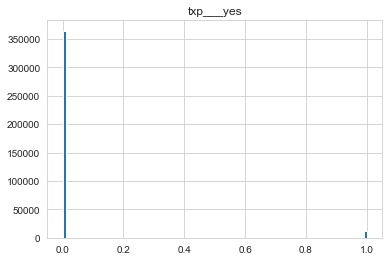

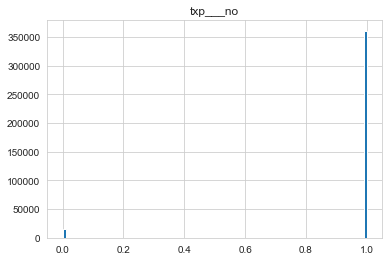

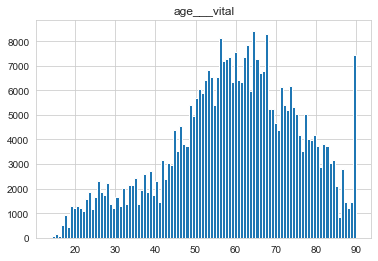

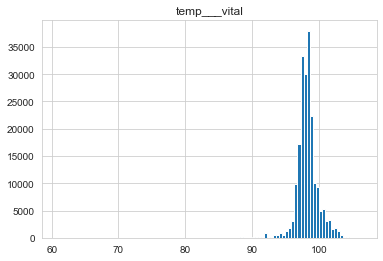

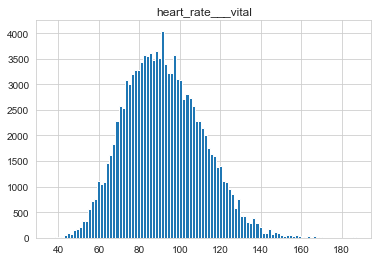

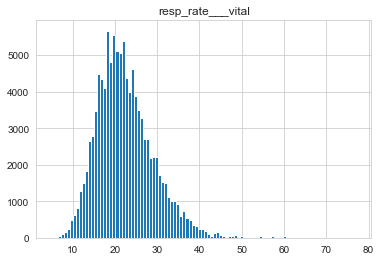

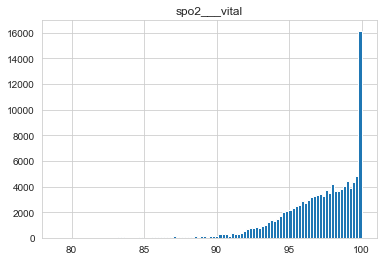

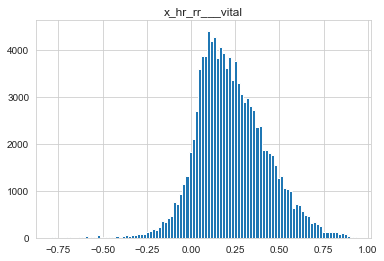

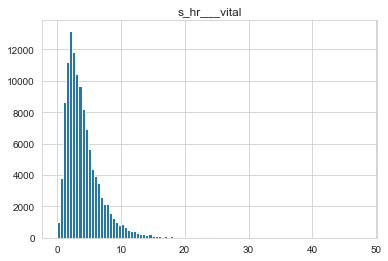

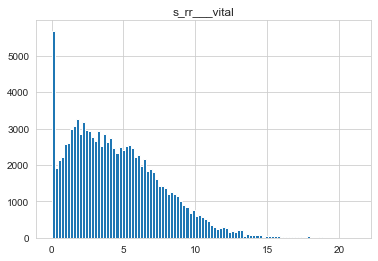

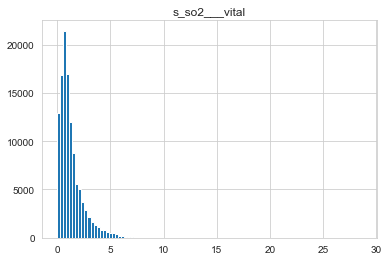

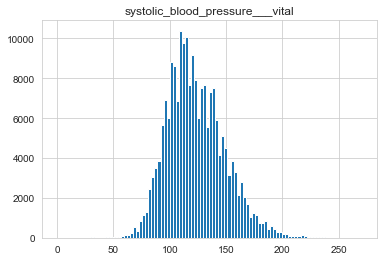

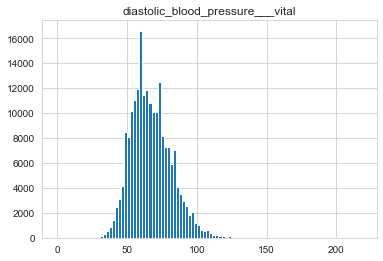

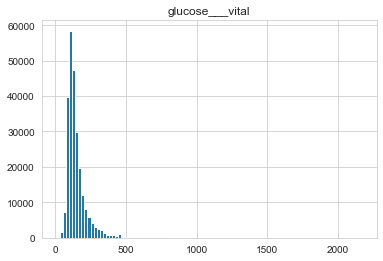

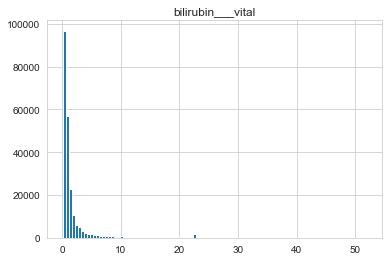

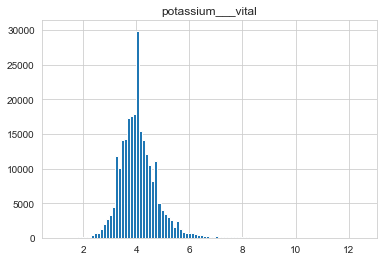

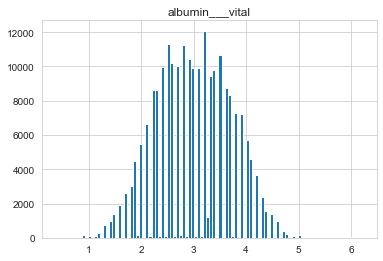

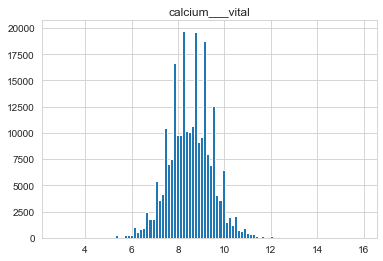

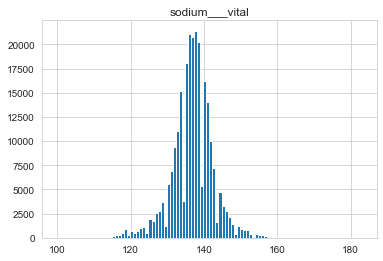

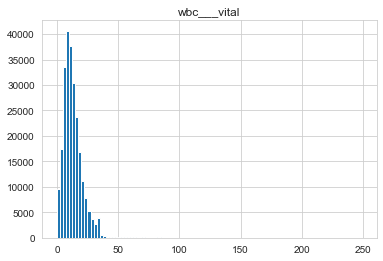

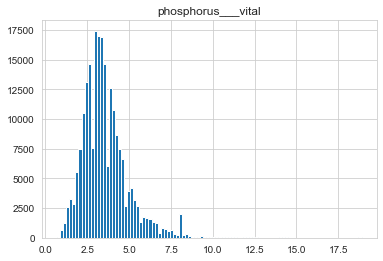

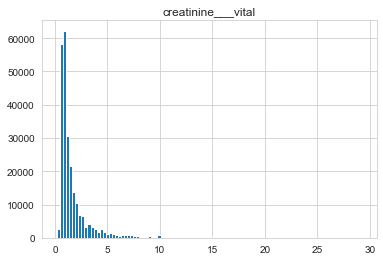

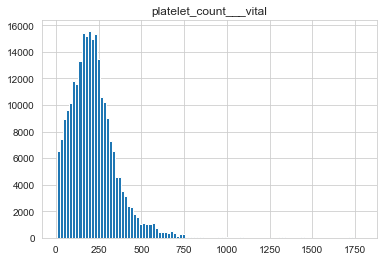

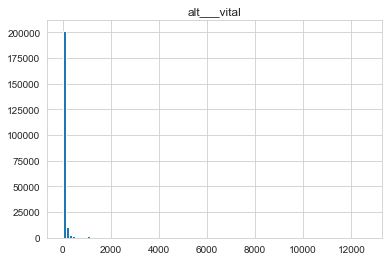

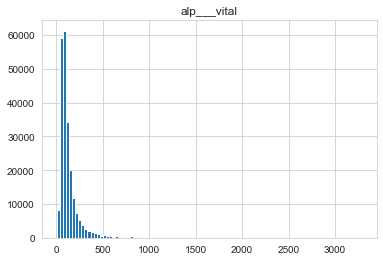

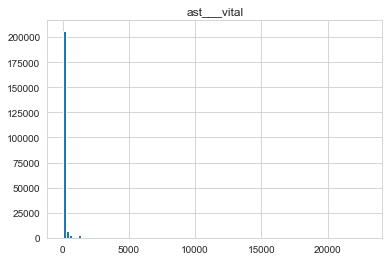

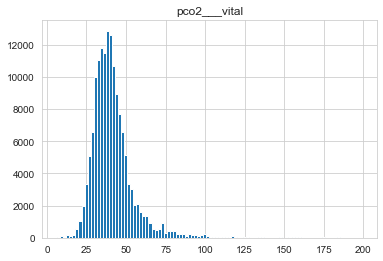

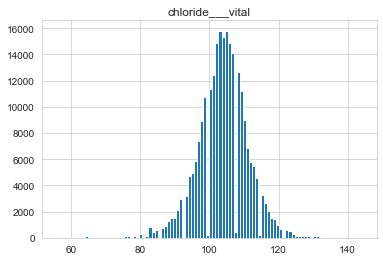

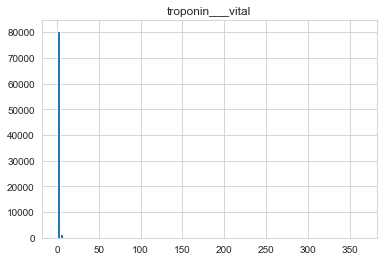

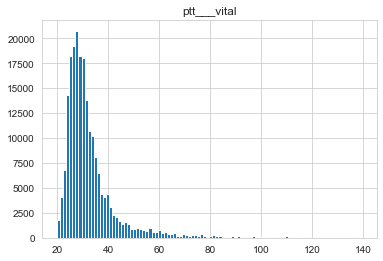

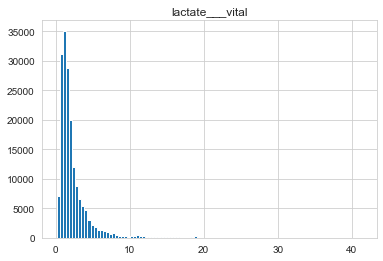

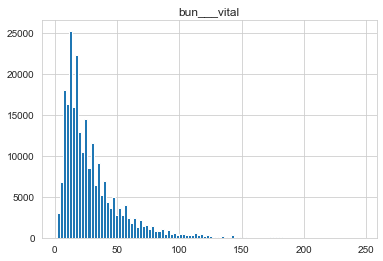

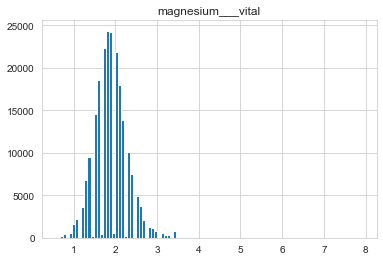

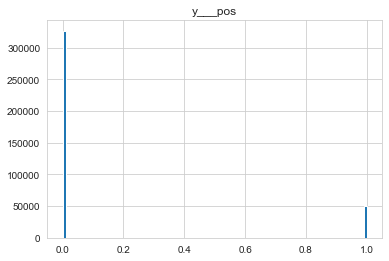

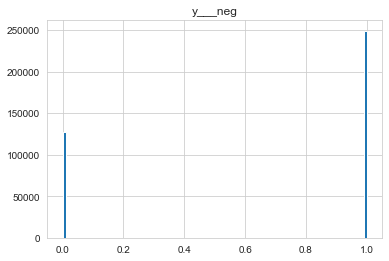

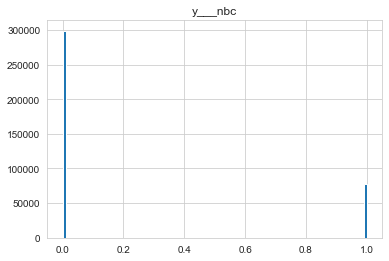

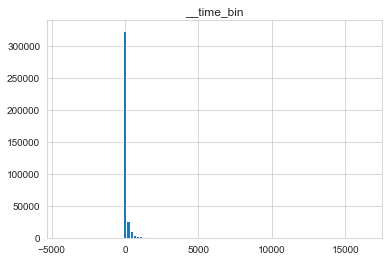

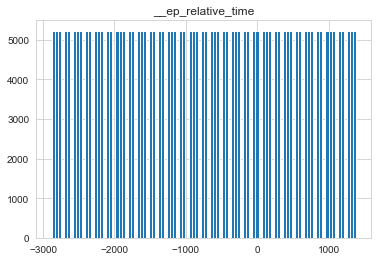

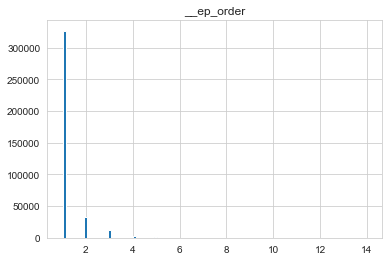

In [10]:
df = bsi_stream.engineer.train_df
for col in df.columns:
    try:
        df.hist(column=col, bins=100);
    except:
        pass

In [17]:
# save raw dataframe in a csv
bsi_stream.engineer.train_df.to_csv("./train_df.csv", index=False)
bsi_stream.engineer.valid_df.to_csv("./valid_df.csv", index=False)
bsi_stream.engineer.train_df_imputed.to_csv("./train_df_median.csv", index=False)
bsi_stream.engineer.valid_df_imputed.to_csv("./valid_df_median.csv", index=False)


## Model comparison

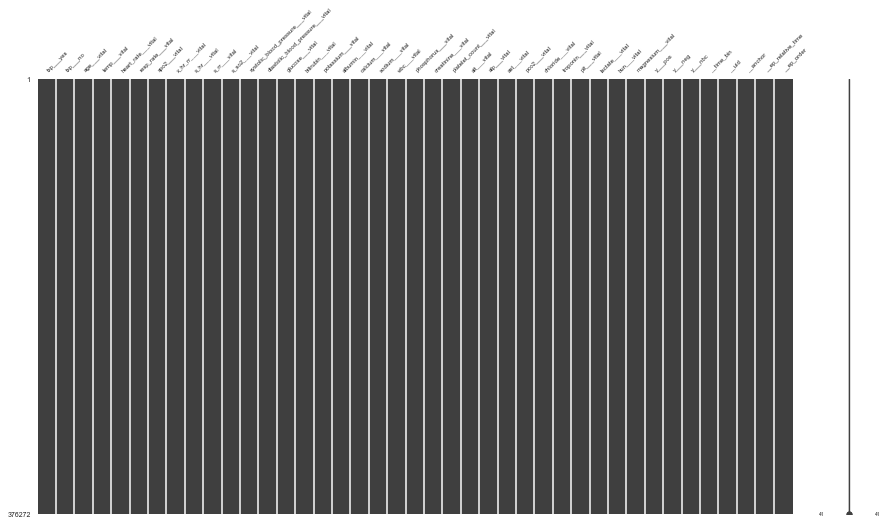

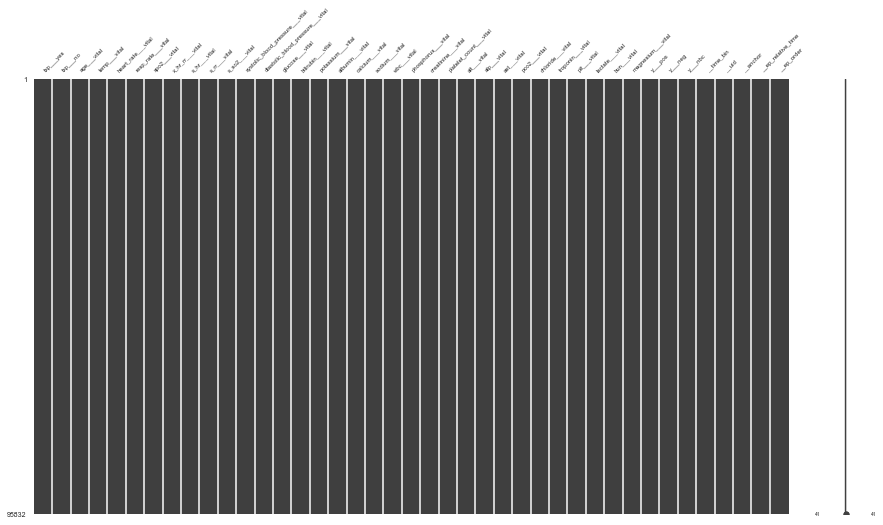

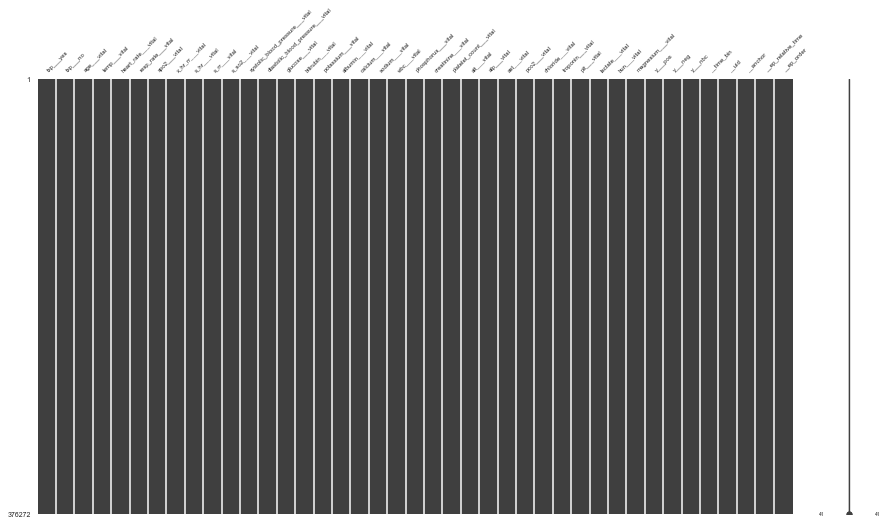

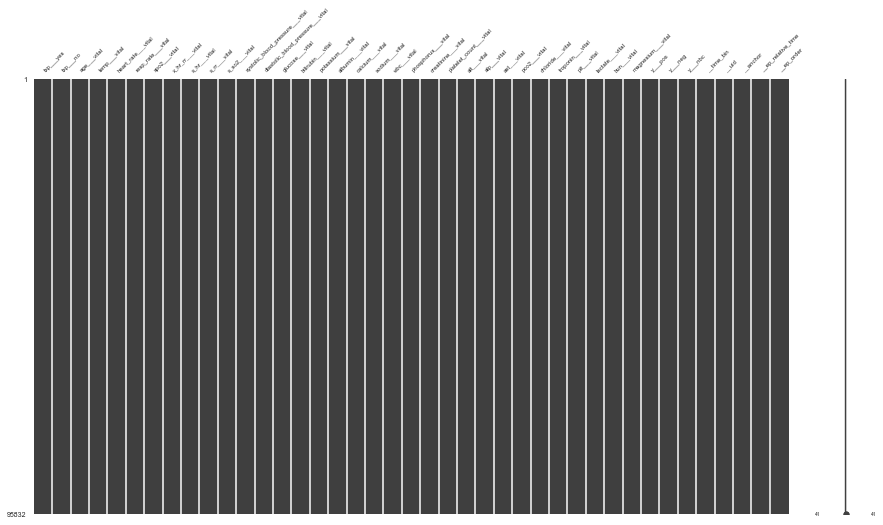

In [5]:
train_df = pd.read_csv("./train_df.csv")
valid_df = pd.read_csv("./valid_df.csv")
whole_df = pd.concat([train_df, valid_df], axis=0)
import missingno as msno
msno.matrix(train_df, figsize=[15, 8], fontsize=6);
msno.matrix(valid_df, figsize=[15, 8], fontsize=6);

train_df.fillna(whole_df.median(), inplace=True)
valid_df.fillna(whole_df.median(), inplace=True)
whole_df.fillna(whole_df.median(), inplace=True)

input_vars = ['txp___yes', 'age___vital', 'temp___vital', 'heart_rate___vital', 'resp_rate___vital', 'spo2___vital', 'x_hr_rr___vital', 's_hr___vital', 's_rr___vital', 's_so2___vital', 'systolic_blood_pressure___vital', 'diastolic_blood_pressure___vital', 'glucose___vital', 'bilirubin___vital', 'potassium___vital', 'albumin___vital', 'calcium___vital', 'sodium___vital', 'wbc___vital', 'phosphorus___vital', 'creatinine___vital', 'platelet_count___vital', 'alt___vital', 'alp___vital', 'ast___vital', 'pco2___vital', 'chloride___vital', 'troponin___vital', 'ptt___vital', 'lactate___vital', 'bun___vital', 'magnesium___vital']
output_var = ['y___pos']


from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer
# median imputation
imputer = SimpleImputer(strategy='median')
imputer.fit(train_df[input_vars])
train_df[input_vars] = imputer.transform(train_df[input_vars])
valid_df[input_vars] = imputer.transform(valid_df[input_vars])

msno.matrix(train_df, figsize=[15, 8], fontsize=6);
msno.matrix(valid_df, figsize=[15, 8], fontsize=6);

In [9]:
# # logistic regression in sklearn
# import sklearn
# from sklearn.linear_model import LogisticRegression

# lr_mdl = LogisticRegression(solver='liblinear').fit(train_df[input_vars], train_df[output_var].values.ravel())
# y_valid_pred = lr_mdl.predict_proba(valid_df[input_vars])
# y_valid_true = valid_df[output_var].values.ravel()
# sklearn.metrics.roc_auc_score(y_valid_true, y_valid_pred[:,1])

## feature importance is measured by "score drop" or it's transformations

#### score drop is the drop in AUC when we permutate the data of a feature at a given time point

In [6]:
# reformat inputs to be 2d image and 1 output per image
X_train = train_df[input_vars].values
Y_train = train_df[output_var].values
X_train = np.reshape(X_train, (-1,72,32) )
Y_train = np.reshape(Y_train, (-1,72,1) )[:,0,:]
print(X_train.shape)
print(Y_train.shape)

(5226, 72, 32)
(5226, 1)


In [7]:
# reformat inputs to be 2d image and 1 output per image
X_valid = valid_df[input_vars].values
Y_valid = valid_df[output_var].values
X_valid = np.reshape(X_valid, (-1,72,32) )
Y_valid = np.reshape(Y_valid, (-1,72,1) )[:,0,:]
print(X_valid.shape)
print(Y_valid.shape)

(1331, 72, 32)
(1331, 1)


In [8]:
# reformat inputs to be 2d image and 1 output per image
X_whole = whole_df[input_vars].values
Y_whole = whole_df[output_var].values
X_whole = np.reshape(X_whole, (-1,72,32) )
Y_whole = np.reshape(Y_whole, (-1,72,1) )[:,0,:]
print(X_whole.shape)
print(Y_whole.shape)

(6557, 72, 32)
(6557, 1)


## LR

In [13]:
myMetrics = [
    keras.metrics.AUC(name='AUROC', curve='ROC'),
    keras.metrics.AUC(name='AUPRC', curve='PR')
]

keras.backend.clear_session()
mdl = keras.models.Sequential([
    keras.layers.Flatten(input_shape=list(X_train.shape)[1:4]),
    keras.layers.Dense(1, activation='sigmoid')
])
mdl.summary()
mdl.compile(loss="binary_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=1e-3), metrics = myMetrics)
callback = EarlyStopping(monitor='val_loss', patience=10)
his = mdl.fit(X_train, Y_train, 
              epochs=50, 
              validation_data=(X_valid,Y_valid), callbacks=[callback])
keras.backend.set_value(mdl.optimizer.learning_rate, 1e-4)
his = mdl.fit(X_train, Y_train, 
              epochs=50, 
              validation_data=(X_valid,Y_valid), callbacks=[callback])
keras.backend.set_value(mdl.optimizer.learning_rate, 1e-5)
his = mdl.fit(X_train, Y_train, 
              epochs=50, 
              validation_data=(X_valid,Y_valid), callbacks=[callback])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 2304)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2305      
Total params: 2,305
Trainable params: 2,305
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
164/164 [==============================] - 1s 3ms/step - loss: 11.6150 - AUROC: 0.5432 - AUPRC: 0.1593 - val_loss: 9.9991 - val_AUROC: 0.5419 - val_AUPRC: 0.1987
Epoch 2/50
164/164 [==============================] - 0s 1ms/step - loss: 4.1938 - AUROC: 0.5955 - AUPRC: 0.2216 - val_loss: 2.5292 - val_AUROC: 0.6669 - val_AUPRC: 0.2869
Epoch 3/50
164/164 [==============================] - 0s 1ms/step - loss: 3.8249 - AUROC: 0.5916 - AUPRC: 0.2036 - val_loss: 5.0476 - val_AUROC: 0.6554 - val_AUPRC: 0.2124

KeyboardInterrupt: 

In [102]:
import random
import sklearn
X_whole_org = np.reshape(whole_df[input_vars].values, (-1,72,32) )
y_prob = mdl.predict(X_whole_org)
y_true = Y_whole
base_score = sklearn.metrics.roc_auc_score(y_true, y_prob)
base_score

0.806739826071595

In [154]:
# score_arr = np.empty(shape=(X_whole_org.shape[1], X_whole_org.shape[2]))

# # permutation in each time point at each variable
# for i in range(X_whole_org.shape[1]):
#     for j in range(X_whole_org.shape[2]):
#         X_whole = X_whole_org.copy()
#         random.shuffle(X_whole[:,i,j])
#         score_arr[i,j] = sklearn.metrics.roc_auc_score(y_true, mdl.predict(X_whole))
# np.save("./score_permuate_lr.npy",score_arr)  

base_score = 0.806739826071595
score_arr = np.load("./score_permuate_lr.npy")
score_delta = base_score - score_arr
score_delta_T = score_delta.T
score_delta_T = score_delta_T - np.min(score_delta_T)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  # Remove the CWD from sys.path while we load stuff.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed

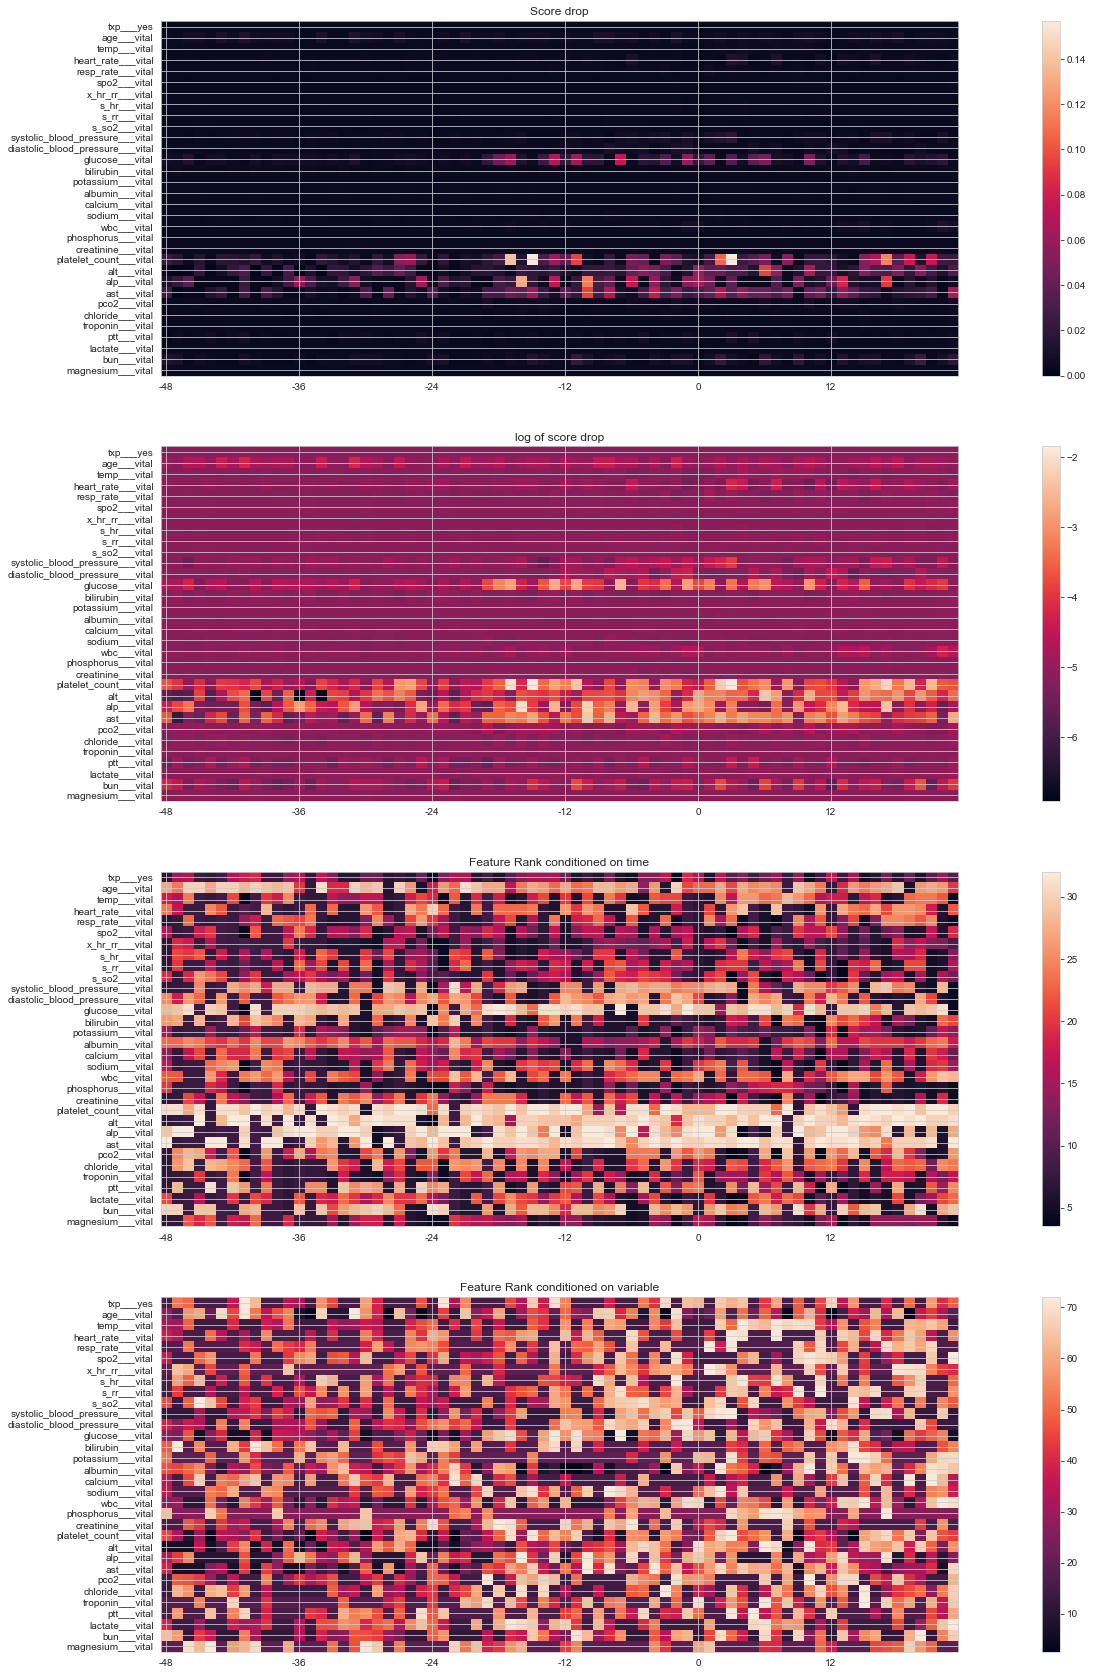

In [170]:
fig, axes = plt.subplots(4,1, figsize=(30,30))
ax = axes.flatten()
im=ax[0].imshow(score_delta_T)
ax[0].set_title("Score drop")
ax[0].tick_params(axis='y', labelrotation=0)
ax[0].set_yticks(range(len(input_vars)))
ax[0].set_yticklabels(input_vars);
ax[0].set_xticks(range(0,72,12))
ax[0].set_xticklabels(range(-48,24,12));
fig.colorbar(im, ax=ax[0])

im=ax[1].imshow(np.log(score_delta_T-np.min(score_delta_T)+0.001))
ax[1].set_title("log of score drop")
ax[1].tick_params(axis='y', labelrotation=0)
ax[1].set_yticks(range(len(input_vars)))
ax[1].set_yticklabels(input_vars);
ax[1].set_xticks(range(0,72,12))
ax[1].set_xticklabels(range(-48,24,12));
fig.colorbar(im, ax=ax[1])

score_delta_T_cut = score_delta.T
score_delta_T_cut[score_delta_T_cut[:,:]<=0]=0

im=ax[2].imshow(scipy.stats.rankdata(score_delta_T_cut, axis=0))
ax[2].set_title("Feature Rank conditioned on time")
ax[2].tick_params(axis='y', labelrotation=0)
ax[2].set_yticks(range(len(input_vars)))
ax[2].set_yticklabels(input_vars);
ax[2].set_xticks(range(0,72,12))
ax[2].set_xticklabels(range(-48,24,12));
fig.colorbar(im, ax=ax[2])

im=ax[3].imshow(scipy.stats.rankdata(score_delta_T_cut, axis=1))
ax[3].set_title("Feature Rank conditioned on variable")
ax[3].tick_params(axis='y', labelrotation=0)
ax[3].set_yticks(range(len(input_vars)))
ax[3].set_yticklabels(input_vars);
ax[3].set_xticks(range(0,72,12))
ax[3].set_xticklabels(range(-48,24,12));
fig.colorbar(im, ax=ax[3])

## LSTM

In [10]:
myMetrics = [
    keras.metrics.AUC(name='AUROC', curve='ROC'),
    keras.metrics.AUC(name='AUPRC', curve='PR')
]

keras.backend.clear_session()
mdl = keras.models.Sequential([
    keras.layers.LSTM(32, return_sequences=True, input_shape=list(X_train.shape)[1:4]),
    keras.layers.BatchNormalization(),
    keras.layers.LSTM(32, return_sequences=False),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(1, activation='sigmoid')
])
mdl.summary()
mdl.compile(loss="binary_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=1e-3), metrics = myMetrics)
callback = EarlyStopping(monitor='val_loss', patience=10)
his = mdl.fit(X_train, Y_train, 
              epochs=50, 
              validation_data=(X_valid,Y_valid), callbacks=[callback])
keras.backend.set_value(mdl.optimizer.learning_rate, 1e-4)
his = mdl.fit(X_train, Y_train, 
              epochs=50, 
              validation_data=(X_valid,Y_valid), callbacks=[callback])
keras.backend.set_value(mdl.optimizer.learning_rate, 1e-5)
his = mdl.fit(X_train, Y_train, 
              epochs=50, 
              validation_data=(X_valid,Y_valid), callbacks=[callback])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 72, 32)            8320      
_________________________________________________________________
batch_normalization (BatchNo (None, 72, 32)            128       
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                8320      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32)                128       
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 16,929
Trainable params: 16,801
Non-trainable params: 128
_________________________________________________________________
Epoch 1/50
164/164 [==============================] - 10s 42ms/step - loss: 0.6774 - AUROC: 0.5386 - AUPRC: 0.1499 -

164/164 [==============================] - 6s 37ms/step - loss: 0.3227 - AUROC: 0.7755 - AUPRC: 0.4334 - val_loss: 0.3715 - val_AUROC: 0.6970 - val_AUPRC: 0.3422
Epoch 8/50
164/164 [==============================] - 6s 37ms/step - loss: 0.3224 - AUROC: 0.7791 - AUPRC: 0.4331 - val_loss: 0.3750 - val_AUROC: 0.6998 - val_AUPRC: 0.3325
Epoch 9/50
164/164 [==============================] - 6s 37ms/step - loss: 0.3205 - AUROC: 0.7790 - AUPRC: 0.4362 - val_loss: 0.3686 - val_AUROC: 0.7108 - val_AUPRC: 0.3452
Epoch 10/50
164/164 [==============================] - 6s 37ms/step - loss: 0.3200 - AUROC: 0.7835 - AUPRC: 0.4397 - val_loss: 0.3694 - val_AUROC: 0.7063 - val_AUPRC: 0.3437
Epoch 11/50
164/164 [==============================] - 6s 37ms/step - loss: 0.3198 - AUROC: 0.7854 - AUPRC: 0.4352 - val_loss: 0.3687 - val_AUROC: 0.7105 - val_AUPRC: 0.3514
Epoch 12/50
164/164 [==============================] - 6s 37ms/step - loss: 0.3187 - AUROC: 0.7857 - AUPRC: 0.4300 - val_loss: 0.3689 - val_AURO

164/164 [==============================] - 6s 39ms/step - loss: 0.2897 - AUROC: 0.8335 - AUPRC: 0.5312 - val_loss: 0.3598 - val_AUROC: 0.7385 - val_AUPRC: 0.4104
Epoch 5/50
164/164 [==============================] - 6s 38ms/step - loss: 0.2858 - AUROC: 0.8388 - AUPRC: 0.5454 - val_loss: 0.3595 - val_AUROC: 0.7385 - val_AUPRC: 0.4103
Epoch 6/50
164/164 [==============================] - 6s 39ms/step - loss: 0.2881 - AUROC: 0.8350 - AUPRC: 0.5384 - val_loss: 0.3589 - val_AUROC: 0.7412 - val_AUPRC: 0.4107
Epoch 7/50
164/164 [==============================] - 6s 39ms/step - loss: 0.2888 - AUROC: 0.8333 - AUPRC: 0.5369 - val_loss: 0.3602 - val_AUROC: 0.7397 - val_AUPRC: 0.4060
Epoch 8/50
164/164 [==============================] - 7s 40ms/step - loss: 0.2884 - AUROC: 0.8357 - AUPRC: 0.5361 - val_loss: 0.3603 - val_AUROC: 0.7399 - val_AUPRC: 0.4058
Epoch 9/50
164/164 [==============================] - 6s 39ms/step - loss: 0.2906 - AUROC: 0.8297 - AUPRC: 0.5308 - val_loss: 0.3600 - val_AUROC: 

KeyboardInterrupt: 

In [177]:
score_arr = np.empty(shape=(X_whole_org.shape[1], X_whole_org.shape[2]))

# # permutation in each time point at each variable
# for i in range(X_whole_org.shape[1]):
#     for j in range(X_whole_org.shape[2]):
#         X_whole = X_whole_org.copy()
#         random.shuffle(X_whole[:,i,j])
#         score_arr[i,j] = sklearn.metrics.roc_auc_score(y_true, mdl.predict(X_whole))
# np.save("./score_permuate_lstm.npy",score_arr)  

base_score = 0.8365871970706795
score_arr = np.load("./score_permuate_lstm.npy")
score_delta = base_score - score_arr
score_delta_T = score_delta.T
score_delta_T = score_delta_T - np.min(score_delta_T)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  # Remove the CWD from sys.path while we load stuff.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed

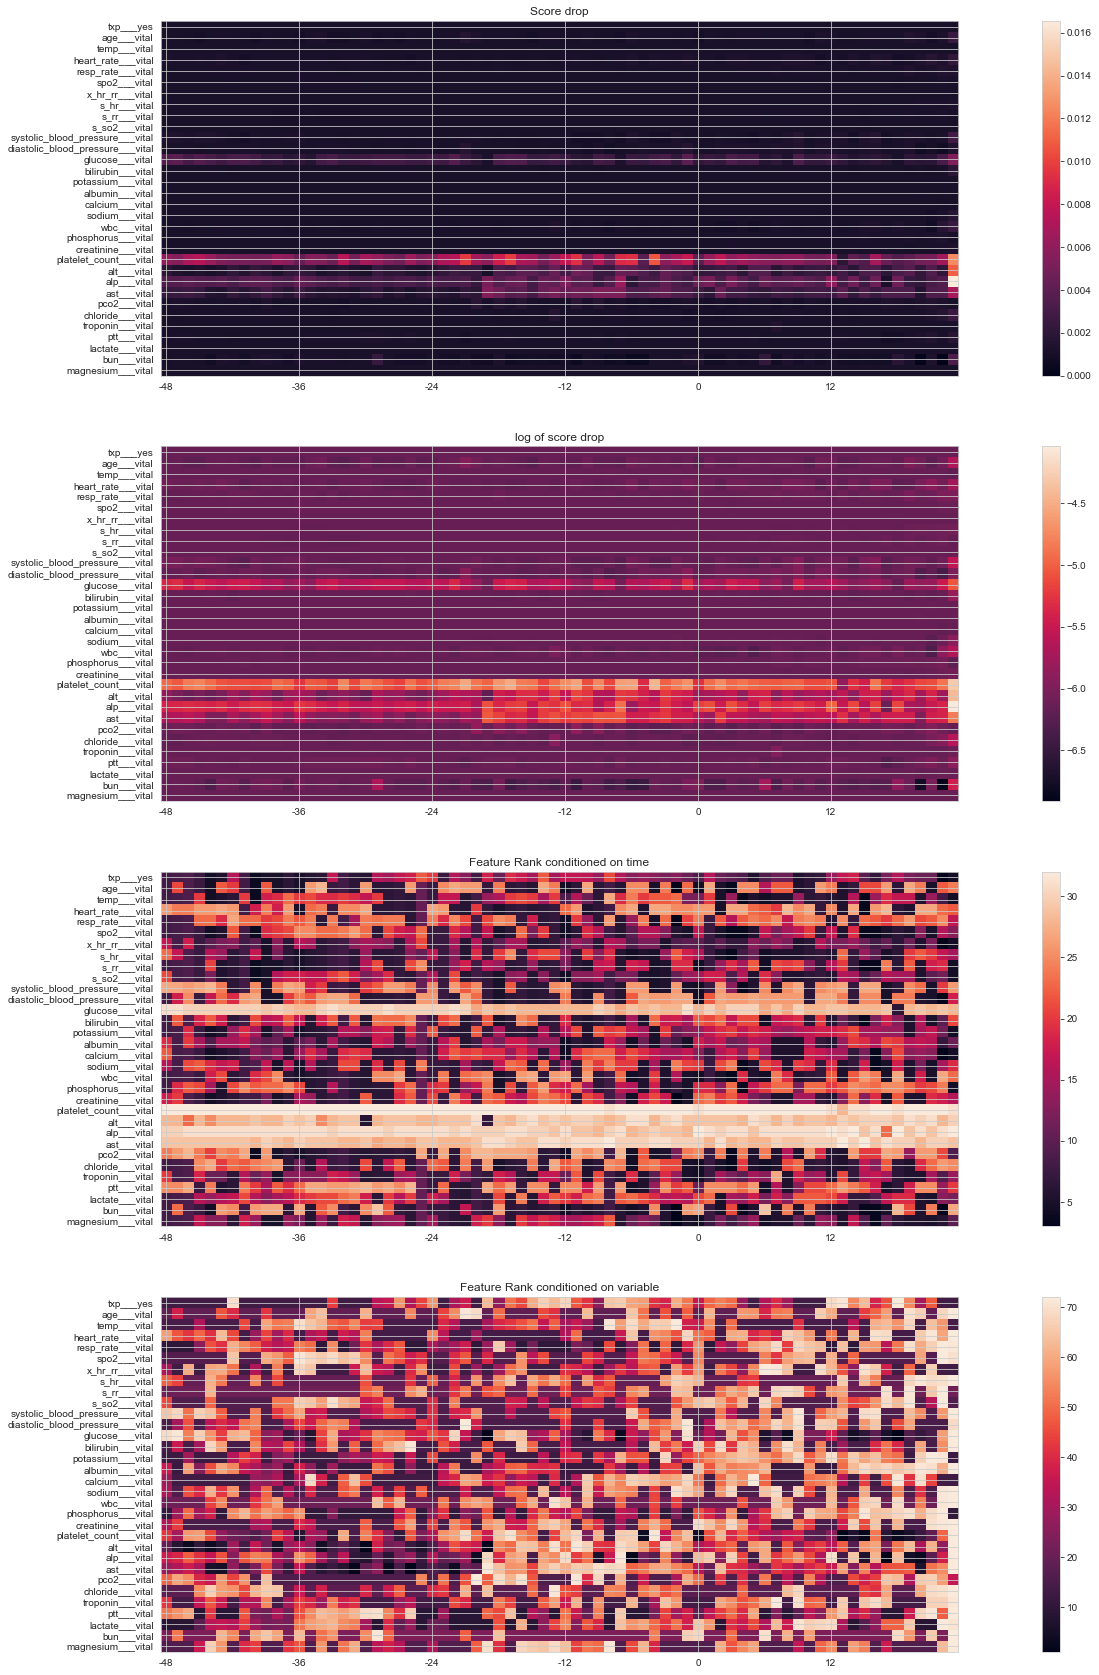

In [178]:
fig, axes = plt.subplots(4,1, figsize=(30,30))
ax = axes.flatten()
im=ax[0].imshow(score_delta_T)
ax[0].set_title("Score drop")
ax[0].tick_params(axis='y', labelrotation=0)
ax[0].set_yticks(range(len(input_vars)))
ax[0].set_yticklabels(input_vars);
ax[0].set_xticks(range(0,72,12))
ax[0].set_xticklabels(range(-48,24,12));
fig.colorbar(im, ax=ax[0])

im=ax[1].imshow(np.log(score_delta_T-np.min(score_delta_T)+0.001))
ax[1].set_title("log of score drop")
ax[1].tick_params(axis='y', labelrotation=0)
ax[1].set_yticks(range(len(input_vars)))
ax[1].set_yticklabels(input_vars);
ax[1].set_xticks(range(0,72,12))
ax[1].set_xticklabels(range(-48,24,12));
fig.colorbar(im, ax=ax[1])

score_delta_T_cut = score_delta.T
score_delta_T_cut[score_delta_T_cut[:,:]<=0]=0

im=ax[2].imshow(scipy.stats.rankdata(score_delta_T_cut, axis=0))
ax[2].set_title("Feature Rank conditioned on time")
ax[2].tick_params(axis='y', labelrotation=0)
ax[2].set_yticks(range(len(input_vars)))
ax[2].set_yticklabels(input_vars);
ax[2].set_xticks(range(0,72,12))
ax[2].set_xticklabels(range(-48,24,12));
fig.colorbar(im, ax=ax[2])

im=ax[3].imshow(scipy.stats.rankdata(score_delta_T_cut, axis=1))
ax[3].set_title("Feature Rank conditioned on variable")
ax[3].tick_params(axis='y', labelrotation=0)
ax[3].set_yticks(range(len(input_vars)))
ax[3].set_yticklabels(input_vars);
ax[3].set_xticks(range(0,72,12))
ax[3].set_xticklabels(range(-48,24,12));
fig.colorbar(im, ax=ax[3])

In [181]:
train_df[input_vars]

,txp___yes,age___vital,temp___vital,heart_rate___vital,resp_rate___vital,spo2___vital,x_hr_rr___vital,s_hr___vital,s_rr___vital,s_so2___vital,...,alt___vital,alp___vital,ast___vital,pco2___vital,chloride___vital,troponin___vital,ptt___vital,lactate___vital,bun___vital,magnesium___vital
0,0.0,51.231263,98.2,90.883588,21.474149,97.541569,0.205479,3.304232,4.020834,0.967990,...,26.0,99.0,33.0,39.2,104.0,0.07,29.7,1.6,22.0,1.9
1,0.0,51.231263,98.2,90.883588,21.474149,97.541569,0.205479,3.304232,4.020834,0.967990,...,26.0,99.0,33.0,39.2,104.0,0.07,29.7,1.6,22.0,1.9
2,0.0,51.231263,98.2,90.883588,21.474149,97.541569,0.205479,3.304232,4.020834,0.967990,...,26.0,99.0,33.0,39.2,104.0,0.07,29.7,1.6,22.0,1.9
3,0.0,51.231263,98.2,90.883588,21.474149,97.541569,0.205479,3.304232,4.020834,0.967990,...,26.0,99.0,33.0,39.2,104.0,0.07,29.7,1.6,22.0,1.9
4,0.0,51.231263,98.2,90.883588,21.474149,97.541569,0.205479,3.304232,4.020834,0.967990,...,26.0,99.0,33.0,39.2,104.0,0.07,29.7,1.6,22.0,1.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
376267,0.0,68.755846,98.2,68.000000,15.323012,96.000000,0.116238,0.000000,8.662775,0.000000,...,55.0,187.0,292.0,39.8,103.0,0.72,51.5,3.7,28.0,2.4
376268,0.0,68.755846,99.3,95.621489,32.529846,94.531298,0.383594,8.030888,1.181384,0.844569,...,28.0,177.0,252.0,39.8,103.0,0.68,51.5,3.7,28.0,2.4
376269,0.0,68.755846,99.3,109.475583,34.441806,93.802607,0.179697,8.144172,1.275171,0.730220,...,28.0,177.0,252.0,39.8,103.0,0.68,51.5,3.7,28.0,2.4
376270,0.0,68.755846,99.3,114.656345,34.799375,93.794766,0.106131,10.784636,1.163085,0.751738,...,28.0,177.0,252.0,39.8,103.0,0.68,51.5,3.7,28.0,2.4


# normalized version

In [45]:
train_df = pd.read_csv("./train_df.csv")
valid_df = pd.read_csv("./valid_df.csv")
whole_df = pd.concat([train_df, valid_df], axis=0)


# reformat inputs to be 2d image and 1 output per image
X_whole = whole_df[input_vars].values
X_whole = (X_whole - X_whole.mean(axis=0))/X_whole.std(axis=0)
Y_whole = whole_df[output_var].values
X_whole = np.reshape(X_whole, (-1,72,32) )
Y_whole = np.reshape(Y_whole, (-1,72,1) )[:,0,:]
print(X_whole.shape)
print(Y_whole.shape)

(6557, 72, 32)
(6557, 1)


In [13]:
myMetrics = [
    keras.metrics.AUC(name='AUROC', curve='ROC'),
    keras.metrics.AUC(name='AUPRC', curve='PR')
]

keras.backend.clear_session()
mdl = keras.models.Sequential([
    keras.layers.LSTM(32, return_sequences=True, input_shape=list(X_train.shape)[1:4]),
    keras.layers.BatchNormalization(),
    keras.layers.LSTM(32, return_sequences=False),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(1, activation='sigmoid')
])
mdl.summary()
mdl.compile(loss="binary_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=1e-3), metrics = myMetrics)
callback = EarlyStopping(monitor='val_loss', patience=3)
his = mdl.fit(X_train, Y_train, 
              epochs=50, 
              validation_data=(X_valid,Y_valid), callbacks=[callback])
keras.backend.set_value(mdl.optimizer.learning_rate, 1e-4)
his = mdl.fit(X_train, Y_train, 
              epochs=50, 
              validation_data=(X_valid,Y_valid), callbacks=[callback])
keras.backend.set_value(mdl.optimizer.learning_rate, 1e-5)
his = mdl.fit(X_train, Y_train, 
              epochs=50, 
              validation_data=(X_valid,Y_valid), callbacks=[callback])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 72, 32)            8320      
_________________________________________________________________
batch_normalization (BatchNo (None, 72, 32)            128       
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                8320      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32)                128       
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 16,929
Trainable params: 16,801
Non-trainable params: 128
_________________________________________________________________
Epoch 1/50
164/164 [==============================] - 9s 40ms/step - loss: 0.6728 - AUROC: 0.5986 - AUPRC: 0.1724 - 

0.9427445516886955


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) fir

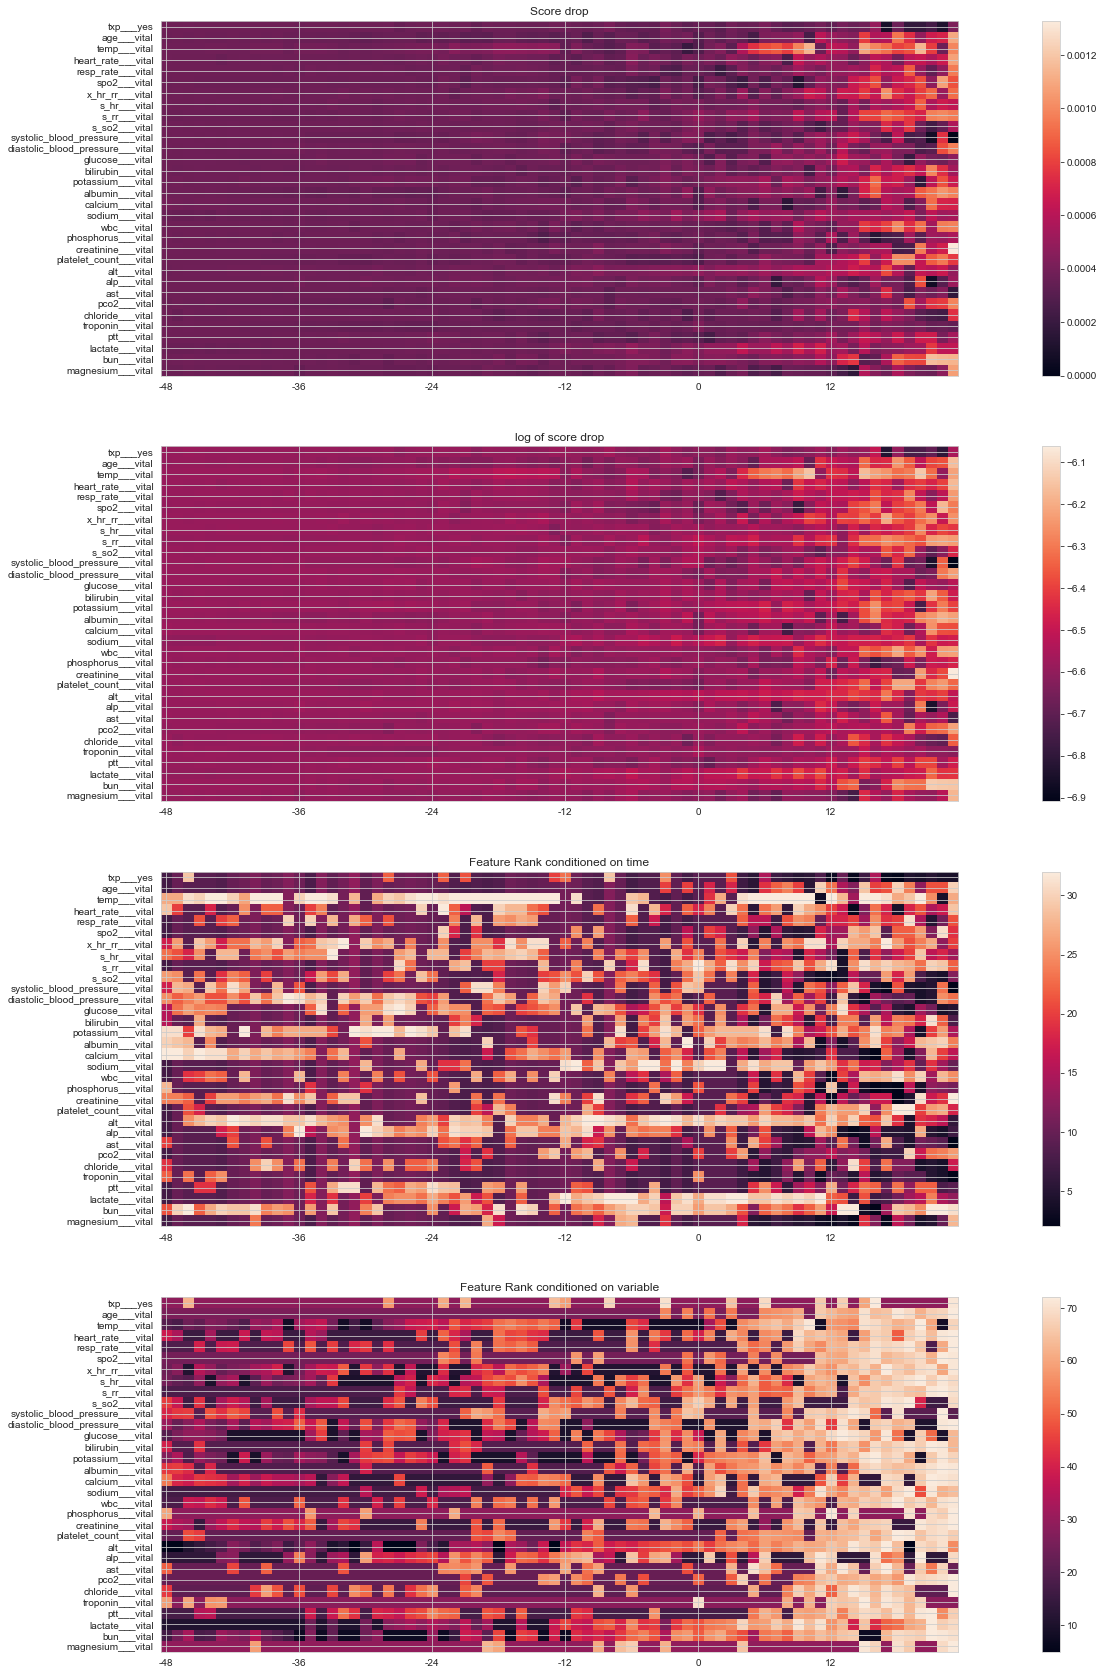

In [191]:
np.save("./score_permuate_lstm_norm.npy",score_arr)  

print(base_score)
score_arr = np.load("./score_permuate_lstm_norm.npy")
score_delta = base_score - score_arr
score_delta_T = score_delta.T
score_delta_T = score_delta_T - np.min(score_delta_T)
fig, axes = plt.subplots(4,1, figsize=(30,30))
ax = axes.flatten()
im=ax[0].imshow(score_delta_T)
ax[0].set_title("Score drop")
ax[0].tick_params(axis='y', labelrotation=0)
ax[0].set_yticks(range(len(input_vars)))
ax[0].set_yticklabels(input_vars);
ax[0].set_xticks(range(0,72,12))
ax[0].set_xticklabels(range(-48,24,12));
fig.colorbar(im, ax=ax[0])

im=ax[1].imshow(np.log(score_delta_T-np.min(score_delta_T)+0.001))
ax[1].set_title("log of score drop")
ax[1].tick_params(axis='y', labelrotation=0)
ax[1].set_yticks(range(len(input_vars)))
ax[1].set_yticklabels(input_vars);
ax[1].set_xticks(range(0,72,12))
ax[1].set_xticklabels(range(-48,24,12));
fig.colorbar(im, ax=ax[1])

score_delta_T_cut = score_delta.T
score_delta_T_cut[score_delta_T_cut[:,:]<=0]=0

im=ax[2].imshow(scipy.stats.rankdata(score_delta_T_cut, axis=0))
ax[2].set_title("Feature Rank conditioned on time")
ax[2].tick_params(axis='y', labelrotation=0)
ax[2].set_yticks(range(len(input_vars)))
ax[2].set_yticklabels(input_vars);
ax[2].set_xticks(range(0,72,12))
ax[2].set_xticklabels(range(-48,24,12));
fig.colorbar(im, ax=ax[2])

im=ax[3].imshow(scipy.stats.rankdata(score_delta_T_cut, axis=1))
ax[3].set_title("Feature Rank conditioned on variable")
ax[3].tick_params(axis='y', labelrotation=0)
ax[3].set_yticks(range(len(input_vars)))
ax[3].set_yticklabels(input_vars);
ax[3].set_xticks(range(0,72,12))
ax[3].set_xticklabels(range(-48,24,12));
fig.colorbar(im, ax=ax[3])

0.9427445516886955


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  from ipykernel import kernelapp as app
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor re

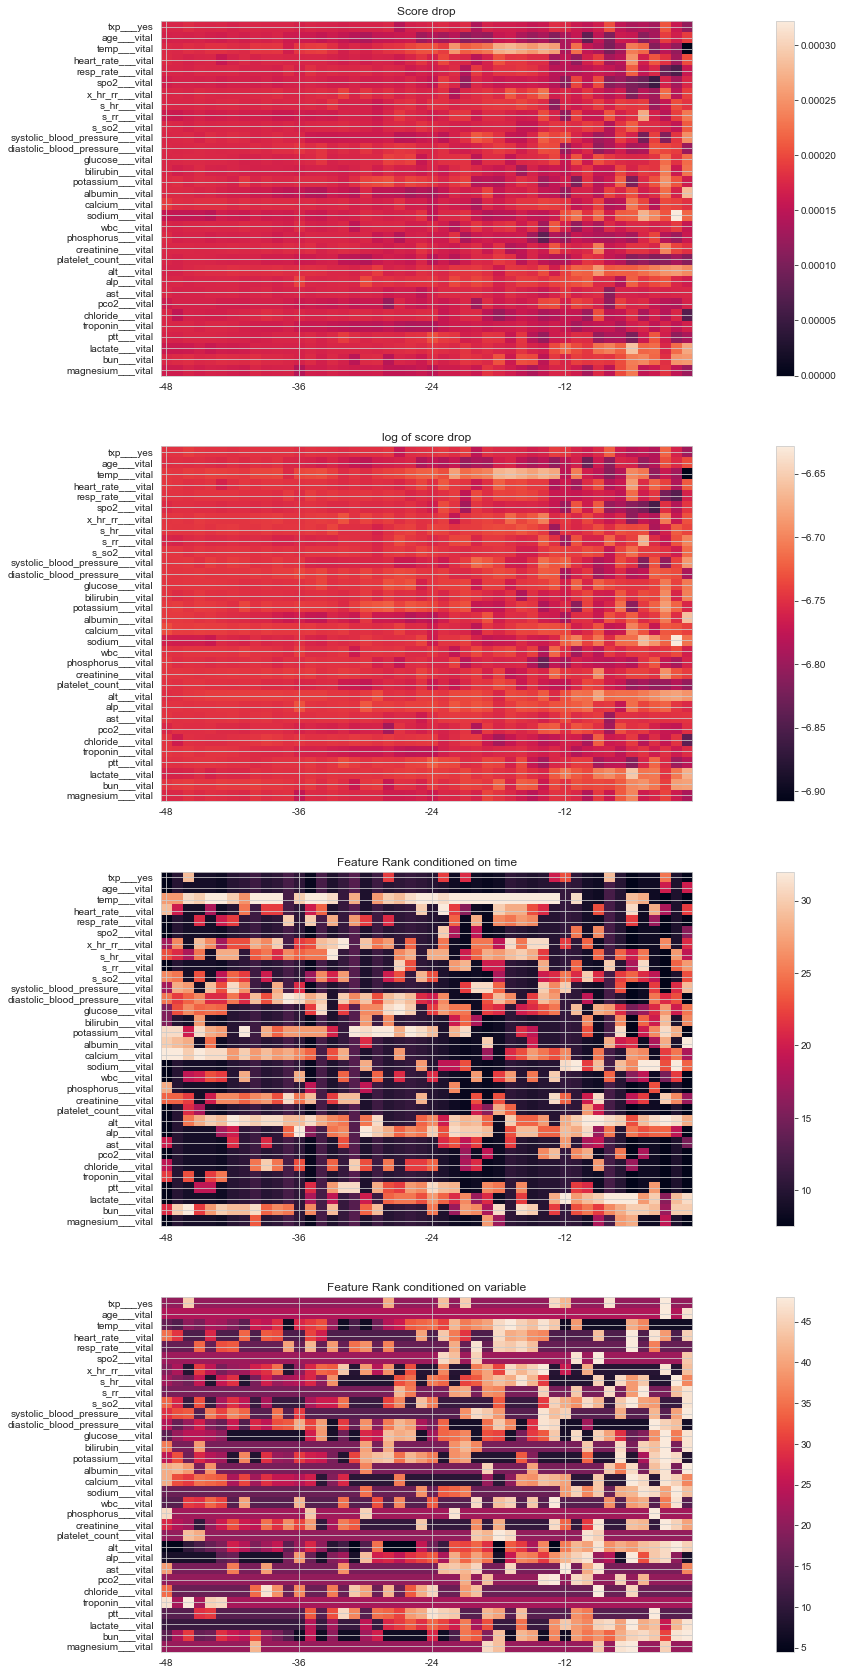

In [199]:
print(base_score)
score_arr = np.load("./score_permuate_lstm_norm.npy")
score_delta = base_score - score_arr
score_delta_T = score_delta[range(48),:].T
score_delta_T = score_delta_T - np.min(score_delta_T)
fig, axes = plt.subplots(4,1, figsize=(30,30))
ax = axes.flatten()
im=ax[0].imshow(score_delta_T)
ax[0].set_title("Score drop")
ax[0].tick_params(axis='y', labelrotation=0)
ax[0].set_yticks(range(len(input_vars)))
ax[0].set_yticklabels(input_vars);
ax[0].set_xticks(range(0,48,12))
ax[0].set_xticklabels(range(-48,0,12));
fig.colorbar(im, ax=ax[0])

im=ax[1].imshow(np.log(score_delta_T-np.min(score_delta_T)+0.001))
ax[1].set_title("log of score drop")
ax[1].tick_params(axis='y', labelrotation=0)
ax[1].set_yticks(range(len(input_vars)))
ax[1].set_yticklabels(input_vars);
ax[1].set_xticks(range(0,48,12))
ax[1].set_xticklabels(range(-48,0,12));
fig.colorbar(im, ax=ax[1])

score_delta_T_cut = score_delta[range(48),:].T
score_delta_T_cut[score_delta_T_cut[:,:]<=0]=0

im=ax[2].imshow(scipy.stats.rankdata(score_delta_T_cut, axis=0))
ax[2].set_title("Feature Rank conditioned on time")
ax[2].tick_params(axis='y', labelrotation=0)
ax[2].set_yticks(range(len(input_vars)))
ax[2].set_yticklabels(input_vars);
ax[2].set_xticks(range(0,48,12))
ax[2].set_xticklabels(range(-48,0,12));
fig.colorbar(im, ax=ax[2])

im=ax[3].imshow(scipy.stats.rankdata(score_delta_T_cut, axis=1))
ax[3].set_title("Feature Rank conditioned on variable")
ax[3].tick_params(axis='y', labelrotation=0)
ax[3].set_yticks(range(len(input_vars)))
ax[3].set_yticklabels(input_vars);
ax[3].set_xticks(range(0,48,12))
ax[3].set_xticklabels(range(-48,0,12));
fig.colorbar(im, ax=ax[3])

In [18]:
range(3, X_whole_org.shape[1])

range(3, 72)

# moving average over time

In [53]:
import random
import sklearn

X_whole_org = np.reshape(whole_df[input_vars].values, (-1,72,32) )
X_whole_org = (X_whole_org - X_whole_org.mean(axis=0))/X_whole_org.std(axis=0)
y_prob = mdl.predict(X_whole_org)
y_true = Y_whole
base_score = sklearn.metrics.roc_auc_score(y_true, y_prob)
print(base_score)
score_arr = np.empty(shape=(X_whole_org.shape[1]-3, X_whole_org.shape[2]))

0.9218013755279683


In [ ]:
# permutation at each time point in each variable
for i in range(3,X_whole_org.shape[1]): # time 
    for j in range(X_whole_org.shape[2]): # variable
        X_whole = X_whole_org.copy()
        print(X_whole[:,range(i-3,i),j])
        values = X_whole[:,range(i-3,i),j].reshape(-1)
        plt.hist(values)
        plt.show()
        np.random.shuffle(values)
        X_whole[:,range(i-3,i),j] = values.reshape(X_whole[:,range(i-3,i),j].shape)
        print(X_whole[:,range(i-3,i),j])
        score_arr[i-3,j] = sklearn.metrics.roc_auc_score(y_true, mdl.predict(X_whole))
        print("---------")
np.save("./score_permuate_lstm_norm_ma.npy",score_arr)  

0.9218013755279683


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) fir

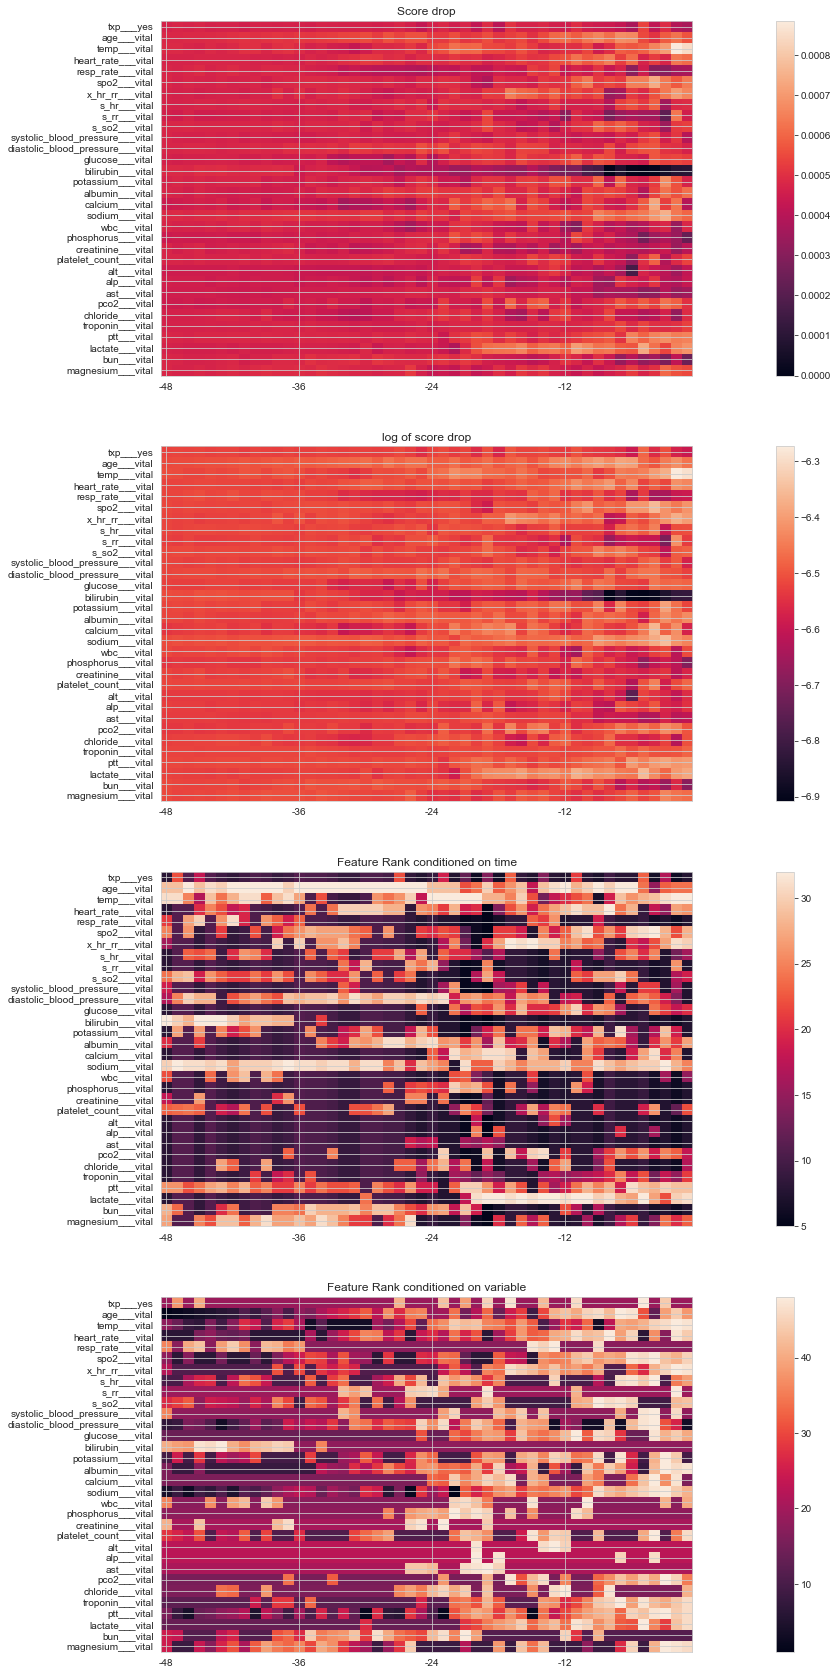

In [56]:
base_score = 0.9218013755279683
print(base_score)
score_arr = np.load("./score_permuate_lstm_norm_ma.npy")
score_delta = base_score - score_arr
score_delta_T = score_delta[range(48),:].T
score_delta_T = score_delta_T - np.min(score_delta_T)
fig, axes = plt.subplots(4,1, figsize=(30,30))
ax = axes.flatten()
im=ax[0].imshow(score_delta_T)
ax[0].set_title("Score drop")
ax[0].tick_params(axis='y', labelrotation=0)
ax[0].set_yticks(range(len(input_vars)))
ax[0].set_yticklabels(input_vars);
ax[0].set_xticks(range(0,48,12))
ax[0].set_xticklabels(range(-48,0,12));
fig.colorbar(im, ax=ax[0])

im=ax[1].imshow(np.log(score_delta_T-np.min(score_delta_T)+0.001))
ax[1].set_title("log of score drop")
ax[1].tick_params(axis='y', labelrotation=0)
ax[1].set_yticks(range(len(input_vars)))
ax[1].set_yticklabels(input_vars);
ax[1].set_xticks(range(0,48,12))
ax[1].set_xticklabels(range(-48,0,12));
fig.colorbar(im, ax=ax[1])

score_delta_T_cut = score_delta[range(48),:].T
score_delta_T_cut[score_delta_T_cut[:,:]<=0]=0

im=ax[2].imshow(scipy.stats.rankdata(score_delta_T_cut, axis=0))
ax[2].set_title("Feature Rank conditioned on time")
ax[2].tick_params(axis='y', labelrotation=0)
ax[2].set_yticks(range(len(input_vars)))
ax[2].set_yticklabels(input_vars);
ax[2].set_xticks(range(0,48,12))
ax[2].set_xticklabels(range(-48,0,12));
fig.colorbar(im, ax=ax[2])

im=ax[3].imshow(scipy.stats.rankdata(score_delta_T_cut, axis=1))
ax[3].set_title("Feature Rank conditioned on variable")
ax[3].tick_params(axis='y', labelrotation=0)
ax[3].set_yticks(range(len(input_vars)))
ax[3].set_yticklabels(input_vars);
ax[3].set_xticks(range(0,48,12))
ax[3].set_xticklabels(range(-48,0,12));
fig.colorbar(im, ax=ax[3])

0.9218013755279683


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


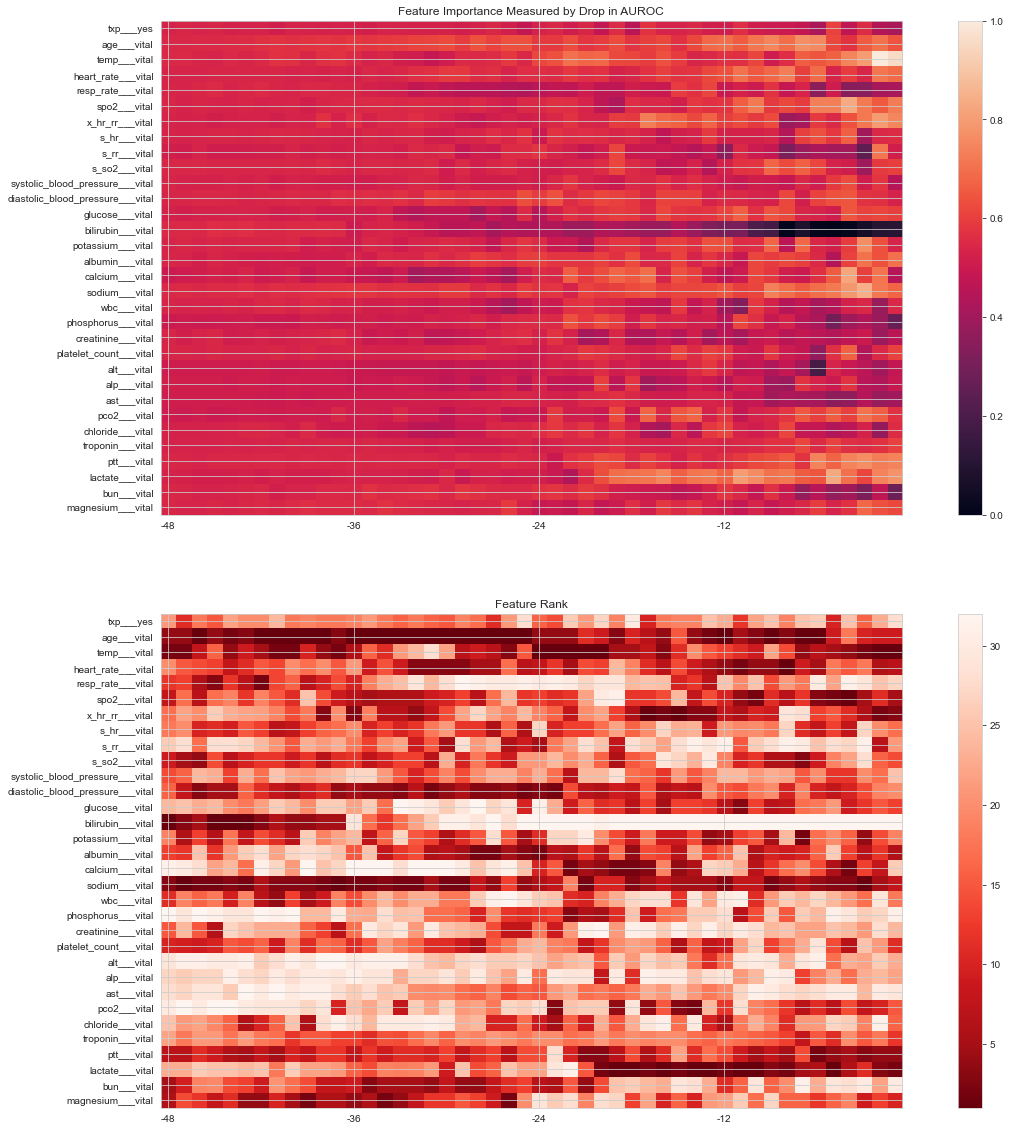

In [12]:
input_vars = ['txp___yes', 'age___vital', 'temp___vital', 'heart_rate___vital', 'resp_rate___vital', 'spo2___vital', 'x_hr_rr___vital', 's_hr___vital', 's_rr___vital', 's_so2___vital', 'systolic_blood_pressure___vital', 'diastolic_blood_pressure___vital', 'glucose___vital', 'bilirubin___vital', 'potassium___vital', 'albumin___vital', 'calcium___vital', 'sodium___vital', 'wbc___vital', 'phosphorus___vital', 'creatinine___vital', 'platelet_count___vital', 'alt___vital', 'alp___vital', 'ast___vital', 'pco2___vital', 'chloride___vital', 'troponin___vital', 'ptt___vital', 'lactate___vital', 'bun___vital', 'magnesium___vital']
output_var = ['y___pos']

base_score = 0.9218013755279683
print(base_score)
score_arr = np.load("./score_permuate_lstm_norm_ma.npy")
score_delta = base_score - score_arr
score_delta_T = score_delta[range(48),:].T
score_delta_T = (score_delta_T - np.min(score_delta_T))/(np.max(score_delta_T)-np.min(score_delta_T))

fig, axes = plt.subplots(2,1, figsize=(20,20))
ax = axes.flatten()
im=ax[0].imshow(score_delta_T)
ax[0].set_title("Feature Importance Measured by Drop in AUROC")
ax[0].tick_params(axis='y', labelrotation=0)
ax[0].set_yticks(range(len(input_vars)))
ax[0].set_yticklabels(input_vars);
ax[0].set_xticks(range(0,48,12))
ax[0].set_xticklabels(range(-48,0,12));
fig.colorbar(im, ax=ax[0])




color_map = plt.cm.get_cmap('Reds')
reversed_color_map = color_map.reversed()
score_delta_T_rank = scipy.stats.rankdata(score_delta_T, axis=0)
score_delta_T_rank = -(score_delta_T_rank-33)

im=ax[1].imshow(score_delta_T_rank, cmap=reversed_color_map)
ax[1].set_title("Feature Rank")
ax[1].tick_params(axis='y', labelrotation=0)
ax[1].set_yticks(range(len(input_vars)))
ax[1].set_yticklabels(input_vars);
ax[1].set_xticks(range(0,48,12))
ax[1].set_xticklabels(range(-48,0,12));
fig.colorbar(im, ax=ax[1])


In [11]:
scipy.stats.rankdata([1,2,3,3,4,4,5])

array([1. , 2. , 3.5, 3.5, 5.5, 5.5, 7. ])

In [8]:
base_score = 0.9218013755279683
print(base_score)
score_arr = np.load("./score_permuate_lstm_norm_ma.npy")
score_delta = base_score - score_arr
score_delta_T = score_delta[range(48),:].T
score_delta_T = (score_delta_T - np.min(score_delta_T))/(np.max(score_delta_T)-np.min(score_delta_T))



0.9218013755279683


array([[21. , 11. , 18. , ..., 16. , 23. , 28. ],
       [ 4. ,  4. ,  1. , ..., 10. ,  9. ,  9. ],
       [ 2. ,  2. ,  8. , ...,  2. ,  1. ,  1. ],
       ...,
       [23. , 23. , 26. , ..., 11. ,  3. ,  2. ],
       [ 5. ,  9.5, 19. , ..., 30. , 22. , 30. ],
       [ 6. , 14. , 12. , ...,  9. , 13. , 10. ]])

## relative risk over time 

In [51]:
train_df = pd.read_csv("./train_df.csv")
valid_df = pd.read_csv("./valid_df.csv")
whole_df = pd.concat([train_df, valid_df], axis=0)

whole_df.fillna(whole_df.median(), inplace=True)

# reformat inputs to be 2d image and 1 output per image
X_whole = whole_df[input_vars].values
X_whole = (X_whole - X_whole.mean(axis=0))/X_whole.std(axis=0)
Y_whole = whole_df[output_var].values
X_whole = np.reshape(X_whole, (-1,72,32) )
Y_whole = np.reshape(Y_whole, (-1,72,1) )[:,0,:]
print(X_whole.shape)
print(Y_whole.shape)

(6557, 72, 32)
(6557, 1)


In [52]:
pos_index = np.where(Y_whole[:,0]==1.0)[0]
neg_index = np.where(Y_whole[:,0]==0.0)[0]
print(pos_index.shape)
print(neg_index.shape)

(877,)
(5680,)


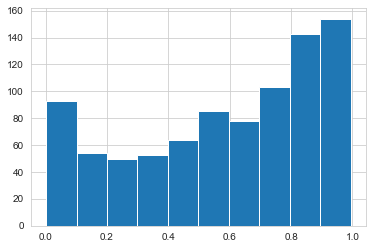

In [58]:
plt.hist(mdl.predict( X_whole[pos_index,:,:]));

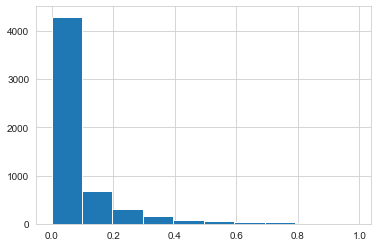

In [59]:
plt.hist(mdl.predict( X_whole[neg_index,:,:]));

In [65]:
i=3
x = X_whole[pos_index,i,:]
X_new = np.repeat(x[:, np.newaxis, :], 72, axis=1)
y_prob1 = mdl.predict(X_new)
y_prob2 = mdl.predict(X_new)
y_prob = np.column_stack((y_prob1,y_prob2))
y_prob = np.column_stack((y_prob,y_prob2))
print(y_prob.shape)

(877, 3)


In [66]:
x = X_whole[pos_index,0,:]
X_new = np.repeat(x[:, np.newaxis, :], 72, axis=1)
y_pos = mdl.predict(X_new)
x = X_whole[neg_index,0,:]
X_new = np.repeat(x[:, np.newaxis, :], 72, axis=1)
y_neg = mdl.predict(X_new)

for i in range(1,X_whole_org.shape[1]):
    print("-------------------")
    x = X_whole[pos_index,i,:]
    X_new = np.repeat(x[:, np.newaxis, :], 72, axis=1)
    y = mdl.predict(X_new)
    print(np.mean(y))
    y_pos = np.column_stack((y_pos,y))
    x = X_whole[neg_index,i,:]
    X_new = np.repeat(x[:, np.newaxis, :], 72, axis=1)
    y = mdl.predict(X_new)
    print(np.mean(y))
    y_neg = np.column_stack((y_neg,y))

-------------------
0.14863199
0.023978554
-------------------
0.14308599
0.024256747
-------------------
0.13874009
0.02413983
-------------------
0.14531872
0.025018344
-------------------
0.14498566
0.025883397
-------------------
0.14867476
0.025863597
-------------------
0.14906052
0.024324825
-------------------
0.14946577
0.024925403
-------------------
0.15199052
0.025450908
-------------------
0.14829734
0.02560608
-------------------
0.14959526
0.025255715
-------------------
0.15321536
0.02540928
-------------------
0.1555726
0.024853779
-------------------
0.14938998
0.024778513
-------------------
0.15214483
0.025093842
-------------------
0.15107225
0.024804907
-------------------
0.15729474
0.025505383
-------------------
0.15395597
0.024713323
-------------------
0.15796001
0.024806583
-------------------
0.15852655
0.024015544
-------------------
0.16258773
0.024310885
-------------------
0.16108379
0.023321431
-------------------
0.17036186
0.024697913
---------------

In [88]:
df_pos = pd.DataFrame(data={'y_prob': y_pos.reshape([-1]), 'time': list(range(-48,24))*y_pos.shape[0]})
df_pos['y_true'] = 'event'
print(df_pos.head(5))
print(df_pos.shape)
df_neg = pd.DataFrame(data={'y_prob': y_neg.reshape([-1]), 'time': list(range(-48,24))*y_neg.shape[0]})
df_neg['y_true'] = 'control'
print(df_neg.head(5))
print(df_neg.shape)
df_res = pd.concat([df_pos,df_neg], axis=0)
basemean = np.mean(Y_whole)
print(basemean)
df_res['risk'] = df_res['y_prob']/basemean
df_res.to_csv("./tte_plot.csv", index=False)

     y_prob  time y_true
0  0.005454   -48  event
1  0.005454   -47  event
2  0.005454   -46  event
3  0.005454   -45  event
4  0.005454   -44  event
(63144, 3)
     y_prob  time   y_true
0  0.005464   -48  control
1  0.005464   -47  control
2  0.005464   -46  control
3  0.005464   -45  control
4  0.005464   -44  control
(408960, 3)
0.13375019063596158


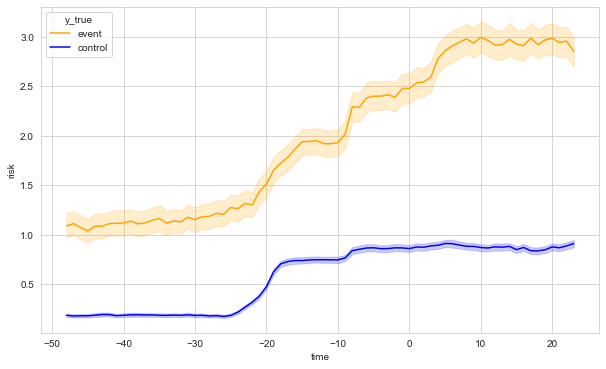

In [93]:
df_res = pd.read_csv("./tte_plot.csv")
plt.figure(figsize=(10,6))
sns.lineplot(data=df_res, x="time", y="risk", hue="y_true", palette=['orange', 'blue']);

In [85]:
df_neg

,y_prob,time,y_true
0,0.005464,1,control
1,0.005464,2,control
2,0.005464,3,control
3,0.005464,4,control
4,0.005464,5,control
...,...,...,...
408955,0.517914,68,control
408956,0.479352,69,control
408957,0.442411,70,control
408958,0.494195,71,control


,y_prob,time,y_true
0,0.005454,1,event
1,0.005454,2,event
2,0.005454,3,event
3,0.005454,4,event
4,0.005454,5,event
...,...,...,...
408955,0.517914,68,control
408956,0.479352,69,control
408957,0.442411,70,control
408958,0.494195,71,control


In [69]:


y_pos.shape

0.13375019063596158


(877, 72)

In [70]:
y_pos.reshape([-1]).shape

(63144,)

In [74]:
list(range(1,73))*y_pos.shape[0]

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 6

In [27]:
x.reshape([x.shape[0], -1, x.shape[1]]).shape

(6557, 1, 32)

In [23]:
i = 3
mdl.predict(x.reshape([x.shape[0], -1, x.shape[1]]))

array([[0.05738148],
       [0.05786011],
       [0.05349773],
       ...,
       [0.06149131],
       [0.06464639],
       [0.05743638]], dtype=float32)

In [ ]:
# permutation at each time point in each variable
for i in range(3,X_whole_org.shape[1]): # time 
    X_whole = X_whole_org.copy()
    print(X_whole[:,range(i-3,i),j])
    values = X_whole[:,range(i-3,i),j].reshape(-1)
    plt.hist(values)
    plt.show()
    np.random.shuffle(values)
    X_whole[:,range(i-3,i),j] = values.reshape(X_whole[:,range(i-3,i),j].shape)
    print(X_whole[:,range(i-3,i),j])
    score_arr[i-3,j] = sklearn.metrics.roc_auc_score(y_true, mdl.predict(X_whole))
    print("---------")
np.save("./score_permuate_lstm_norm_ma.npy",score_arr)  